# Caso Práctico: DBSCAN

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

## Imports

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np

## Funciones auxiliares

In [24]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## 1. Lectura del conjunto de datos

In [25]:
df = pd.read_csv("datasets/creditcard.csv")

## 2. Visualización del conjunto de datos

In [27]:
#df.head(10)

In [28]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


In [29]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [30]:
# Visualizamos los tipos de cada uno de los atributos
#df.info()

In [32]:
# Comprobamos si alguna columna tiene valores nulos
#df.isna().any()

In [ ]:
# Representamos gráficamente las características
features = df.drop("Class", axis=1)

plt.figure(figsize=(12, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Class == 1
    sns.histplot(data=df[df["Class"] == 1], x=f, kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
    # Usando histplot para los casos donde Class == 0
    sns.histplot(data=df[df["Class"] == 0], x=f, kde=True, color="blue", stat="density", label="Legit", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

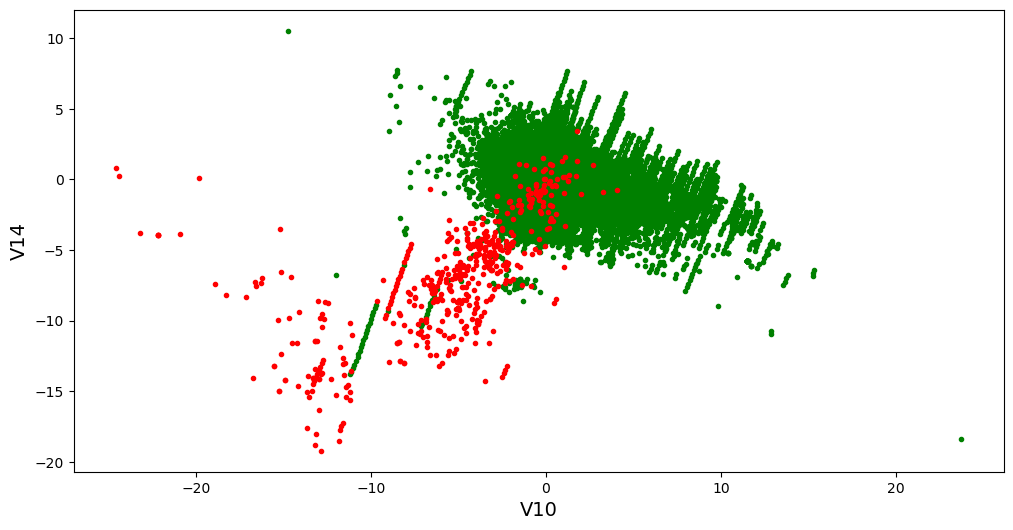

In [33]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [34]:
df = df.drop(["Time", "Amount"], axis=1)

## 4. DBSCAN con un conjunto de datos de dos dimensiones

Antes de comenzar con el entrenamiento de DBSCAN para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.

In [37]:
X = df[["V10", "V14"]].copy()
y = df["Class"].copy()
X.shape

(284807, 2)

In [36]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15, min_samples=13)
dbscan.fit(X)

MemoryError: bad allocation

In [20]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker=".", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [ ]:
plt.figure(figsize=(12, 6))
plot_dbscan(dbscan, X.values, size=100)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [ ]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

## 5. Reducción del número de características

In [ ]:
X = df.drop("Class", axis=1)
y = df["Class"].copy()

### Aplicamos selección de características con _Random Forest_

### Entrenamiento de DBSCAN con el conjunto de datos reducido

## 6. Evaluación de los resultados

Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.

## 7. Problemas típicos que pueden resolverse con DBSCAN

DBSCAN es útil para solucionar problemas como el que se plantea a continuación.

In [16]:
# Generamos un conjunto de datos
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

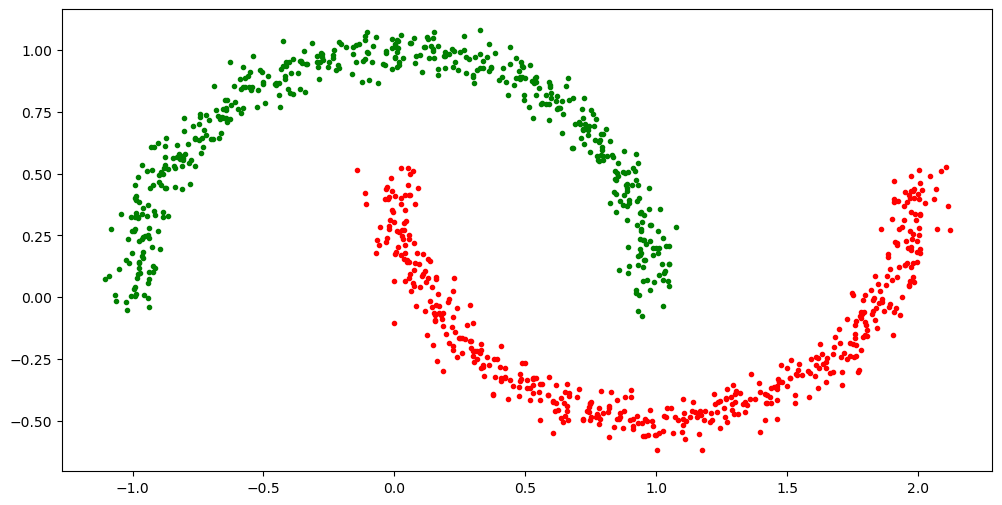

In [17]:
plt.figure(figsize=(12, 6))
plt.scatter(X[:,0][y == 0], X[:,1][y == 0], c="g", marker=".")
plt.scatter(X[:,0][y == 1], X[:,1][y == 1], c="r", marker=".")
plt.show()

In [18]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=6)
dbscan.fit(X)

DBSCAN(eps=0.1, min_samples=6)

<Figure size 1200x600 with 0 Axes>

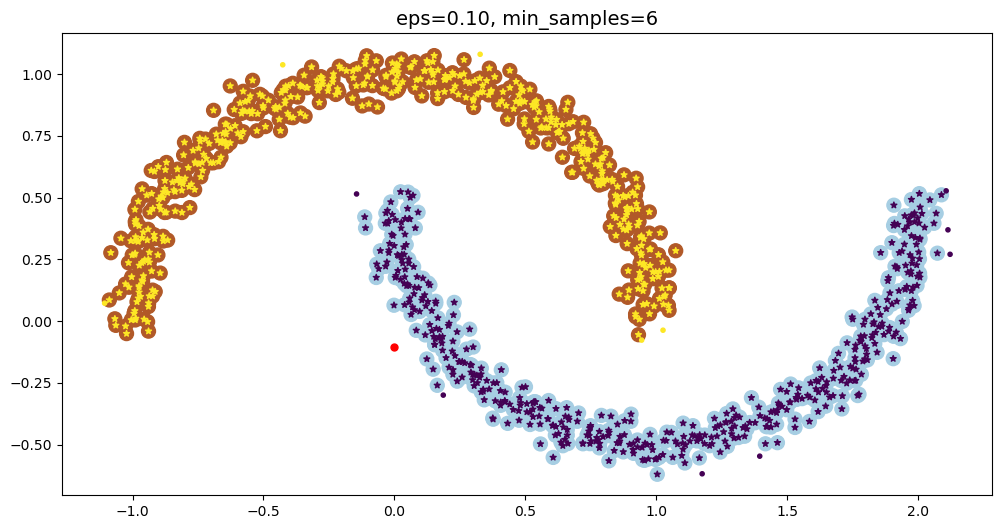

In [21]:
# Representamos el límite de decisión
plt.figure(figsize=(12, 6))
plot_dbscan(dbscan, X, size=100)
plt.show()

In [22]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label -1 has 1 samples - 1 are malicious samples
Label 0 has 499 samples - 499 are malicious samples
Label 1 has 500 samples - 0 are malicious samples
